# Wikipedia Text Generation (using RNN)

> - 🤖 See [full list of Machine Learning Experiments](https://github.com/trekhleb/machine-learning-experiments) on GitHub
> - ▶️ Demo: [try this model in action](https://trekhleb.github.io/machine-learning-experiments)

## Experiment overview

In this experiment we will use character-based [Recurrent Neural Network](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNN) to generate a Wikipedia-like text based on the [wikipedia](https://www.tensorflow.org/datasets/catalog/wikipedia) TensorFlow dataset.

_Inspired by [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation)_

## Import dependencies

In [1]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
# %tensorflow_version 2.x

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.6
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


## Download the dataset

[Wikipedia](https://www.tensorflow.org/datasets/catalog/wikipedia) dataset contains cleaned articles of all languages. The datasets are built from the [Wikipedia dump](https://dumps.wikimedia.org/) with one split per language. Each example contains the content of one full Wikipedia article with cleaning to strip markdown and unwanted sections (references, etc.).

In [3]:
# List all available datasets to see how the wikipedia dataset is called.
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'cos_e',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'esnli',
 'eurosat',
 'fashion_mnist',
 'flic',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'groove',
 'higgs',
 'horses_or_humans',
 'i_natura

[`tfds.load`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) is a convenience method that's the simplest way to build and load a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [4]:
# Loading the wikipedia dataset.
# DATASET_NAME = 'wikipedia/20190301.en'
DATASET_NAME = 'wikipedia/20190301.uk'

dataset, dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    split=tfds.Split.TRAIN,
)

In [5]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='wikipedia',
    version=1.0.0,
    description='Wikipedia dataset containing cleaned articles of all languages.
The datasets are built from the Wikipedia dump
(https://dumps.wikimedia.org/) with one split per language. Each example
contains the content of one full Wikipedia article with cleaning to strip
markdown and unwanted sections (references, etc.).
',
    homepage='https://dumps.wikimedia.org',
    features=FeaturesDict({
        'text': Text(shape=(), dtype=tf.string),
        'title': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=1131279,
    splits={
        'train': 1131279,
    },
    supervised_keys=None,
    citation="""@ONLINE {wikidump,
        author = "Wikimedia Foundation",
        title  = "Wikimedia Downloads",
        url    = "https://dumps.wikimedia.org"
    }""",
    redistribution_info=license: "This work is licensed under the Creative Commons Attribution-ShareAlike 3.0 Unported License. To view a copy of this 

In [6]:
print(dataset)

<DatasetV1Adapter shapes: {text: (), title: ()}, types: {text: tf.string, title: tf.string}>


## Analyze the dataset

In [7]:
TRAIN_NUM_EXAMPLES = dataset_info.splits['train'].num_examples
print('Total number of articles: ', TRAIN_NUM_EXAMPLES)

Total number of articles:  1131279


In [8]:
print('First article','\n======\n')
for example in dataset.take(1):
    print('Title:','\n------')
    print(example['title'].numpy().decode('utf-8'))
    print()

    print('Text:', '\n------')
    print(example['text'].numpy().decode('utf-8'))

First article 

Title: 
------
Заровенька

Text: 
------
Заровенька, Зровень — річка в Україні, у Ємільчинському районі Житомирської області, права притока Малої Глумчи (басейн Прип'яті).

Опис 
Довжина річки 13 км., похил річки — 1,&nb3sp;м/км. Формується з багатьох безіменних струмків. Площа басейну 65,4 км².

Розташування 
Бере початок на південному заході від села Просіка. Тече на північний схід в межах сіл Заровенка та Медведеве. На околиці села Паранине впадає у річку Малу Глумчу, притоку Уборті.

Риби Заровеньки 
У річці водиться щука звичайна, бистрянка звичайна, карась звичайний, окунь, пічкур та плітка звичайна.

Джерела 
 «Каталог річок України». — К. : Видавництво АН УРСР, 1957. — С. 83. — (№ 1340).

Категорія:Малі річки України
Категорія:Річки Житомирської області
Категорія:Ємільчинський район
Категорія:Річки Ємільчинського району


## Process the dataset

### Flatten the dataset

Converting the dataset from the set of articles into the set of characters. We also are interested only in `text` of each article so we may drop the `title` along the way.

In [9]:
def article_to_text(text):
    return np.array([char for char in text.numpy().decode('utf-8')])

# Converting each dataset item to a string ('text') instead of a dictionary ({'text', 'title'}).
dataset_text = dataset.map(
    lambda article: tf.py_function(func=article_to_text, inp=[article['text']], Tout=tf.string)
)

for text in dataset_text.take(2):
    print(text.numpy())
    print('\n')

[b'\xd0\x97' b'\xd0\xb0' b'\xd1\x80' b'\xd0\xbe' b'\xd0\xb2' b'\xd0\xb5'
 b'\xd0\xbd' b'\xd1\x8c' b'\xd0\xba' b'\xd0\xb0' b',' b' ' b'\xd0\x97'
 b'\xd1\x80' b'\xd0\xbe' b'\xd0\xb2' b'\xd0\xb5' b'\xd0\xbd' b'\xd1\x8c'
 b'\xc2\xa0' b'\xe2\x80\x94' b' ' b'\xd1\x80' b'\xd1\x96' b'\xd1\x87'
 b'\xd0\xba' b'\xd0\xb0' b' ' b'\xd0\xb2' b' ' b'\xd0\xa3' b'\xd0\xba'
 b'\xd1\x80' b'\xd0\xb0' b'\xd1\x97' b'\xd0\xbd' b'\xd1\x96' b',' b' '
 b'\xd1\x83' b' ' b'\xd0\x84' b'\xd0\xbc' b'\xd1\x96' b'\xd0\xbb'
 b'\xd1\x8c' b'\xd1\x87' b'\xd0\xb8' b'\xd0\xbd' b'\xd1\x81' b'\xd1\x8c'
 b'\xd0\xba' b'\xd0\xbe' b'\xd0\xbc' b'\xd1\x83' b' ' b'\xd1\x80'
 b'\xd0\xb0' b'\xd0\xb9' b'\xd0\xbe' b'\xd0\xbd' b'\xd1\x96' b' '
 b'\xd0\x96' b'\xd0\xb8' b'\xd1\x82' b'\xd0\xbe' b'\xd0\xbc' b'\xd0\xb8'
 b'\xd1\x80' b'\xd1\x81' b'\xd1\x8c' b'\xd0\xba' b'\xd0\xbe' b'\xd1\x97'
 b' ' b'\xd0\xbe' b'\xd0\xb1' b'\xd0\xbb' b'\xd0\xb0' b'\xd1\x81'
 b'\xd1\x82' b'\xd1\x96' b',' b' ' b'\xd0\xbf' b'\xd1\x80' b'\xd0\xb0'
 b'\xd0\xb2' b'\x

In [10]:
# Unbatch the text dataset into a more granular char dataset.
# Now each dataset item is one character instead of a big piece of text.
dataset_chars = dataset_text.unbatch()

for char in dataset_chars.take(20):
    print(char.numpy().decode('utf-8'))

З
а
р
о
в
е
н
ь
к
а
,
 
З
р
о
в
е
н
ь
 


### Generating vocabulary

In [11]:
vocab = set()

# Ideally we should take all dataset items into account here.
for text in dataset_text.take(1000):
    vocab.update([char.decode('utf-8') for char in text.numpy()])
    
vocab = sorted(vocab)

print('Unique characters: {}'.format(len(vocab)))
print('vocab:')
print(vocab)

Unique characters: 384
vocab:
['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '\xa0', '£', '«', '°', '²', '³', '´', '·', 'º', '»', '½', '¿', 'Á', 'Ç', 'È', 'É', 'Í', 'Ó', 'Ö', '×', 'Þ', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'ð', 'ñ', 'ò', 'ó', 'ö', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'þ', 'Ā', 'ā', 'ă', 'ą', 'ć', 'Č', 'č', 'ę', 'ě', 'Ł', 'ł', 'Ń', 'ń', 'ō', 'œ', 'Ś', 'ś', 'š', 'ť', 'ų', 'ż', 'Ž', 'ž', 'ș', 'ˆ', '́', 'Ά', 'Α', 'Κ', 'Λ', 'Τ', 'ά', 'α', 'γ', 'ε', 'ι', 'λ', 'μ', 'ν', 'ο', 'π', 'ρ', 'ς', 'σ', 'τ', 'υ', 'χ', 'ϊ', 'ό', 'ύ', 'Є', 'І'

### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [12]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(30)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\t':   0,
  '\n':   1,
  ' ' :   2,
  '!' :   3,
  '"' :   4,
  '#' :   5,
  '$' :   6,
  '%' :   7,
  '&' :   8,
  "'" :   9,
  '(' :  10,
  ')' :  11,
  '*' :  12,
  '+' :  13,
  ',' :  14,
  '-' :  15,
  '.' :  16,
  '/' :  17,
  '0' :  18,
  '1' :  19,
  '2' :  20,
  '3' :  21,
  '4' :  22,
  '5' :  23,
  '6' :  24,
  '7' :  25,
  '8' :  26,
  '9' :  27,
  ':' :  28,
  ';' :  29,
  ...
}


In [13]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)

print(index2char)

['\t' '\n' ' ' '!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/'
 '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' ':' ';' '<' '=' '>' '?' 'A' 'B'
 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T'
 'U' 'V' 'W' 'X' 'Y' 'Z' '[' '\\' ']' '_' '`' 'a' 'b' 'c' 'd' 'e' 'f' 'g'
 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y'
 'z' '{' '|' '}' '\xa0' '£' '«' '°' '²' '³' '´' '·' 'º' '»' '½' '¿' 'Á'
 'Ç' 'È' 'É' 'Í' 'Ó' 'Ö' '×' 'Þ' 'ß' 'à' 'á' 'â' 'ã' 'ä' 'å' 'ç' 'è' 'é'
 'ê' 'ë' 'ì' 'í' 'ð' 'ñ' 'ò' 'ó' 'ö' 'ø' 'ù' 'ú' 'û' 'ü' 'ý' 'þ' 'Ā' 'ā'
 'ă' 'ą' 'ć' 'Č' 'č' 'ę' 'ě' 'Ł' 'ł' 'Ń' 'ń' 'ō' 'œ' 'Ś' 'ś' 'š' 'ť' 'ų'
 'ż' 'Ž' 'ž' 'ș' 'ˆ' '́' 'Ά' 'Α' 'Κ' 'Λ' 'Τ' 'ά' 'α' 'γ' 'ε' 'ι' 'λ' 'μ'
 'ν' 'ο' 'π' 'ρ' 'ς' 'σ' 'τ' 'υ' 'χ' 'ϊ' 'ό' 'ύ' 'Є' 'І' 'Ї' 'А' 'Б' 'В'
 'Г' 'Д' 'Е' 'Ж' 'З' 'И' 'Й' 'К' 'Л' 'М' 'Н' 'О' 'П' 'Р' 'С' 'Т' 'У' 'Ф'
 'Х' 'Ц' 'Ч' 'Ш' 'Щ' 'Ы' 'Ь' 'Э' 'Ю' 'Я' 'а' 'б' 'в' 'г' 'д' 'е' 'ж' 'з'
 'и' 'й' 'к' 'л' 'м' 'н' 'о' 'п' 'р' 'с' 'т' 'у' 

In [14]:
def char_to_index(char):
    char_symbol = char.numpy().decode('utf-8')
    char_index = char2index[char_symbol] if char_symbol in char2index else char2index['?']
    return char_index

dataset_chars_indexed = dataset_chars.map(
    lambda char: tf.py_function(func=char_to_index, inp=[char], Tout=tf.int32)
)

print('ORIGINAL CHARS:', '\n---')
for char in dataset_chars.take(10):
    print(char.numpy().decode())

print('\n\n')    
    
print('INDEXED CHARS:', '\n---')
for char_index in dataset_chars_indexed.take(10):
    print(char_index.numpy())

ORIGINAL CHARS: 
---
З
а
р
о
в
е
н
ь
к
а



INDEXED CHARS: 
---
201
225
241
239
227
230
238
253
235
225


## Create training sequences

In [15]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 100

In [16]:
# Generate batched sequences out of the char_dataset.
sequences = dataset_chars_indexed.batch(sequence_length + 1, drop_remainder=True)

# Sequences examples.
for item in sequences.take(10):
    print(repr(''.join(index2char[item.numpy()])))

'Заровенька, Зровень\xa0— річка в Україні, у Ємільчинському районі Житомирської області, права притока Ма'
"лої Глумчи (басейн Прип'яті).\n\nОпис \nДовжина річки 13\xa0км., похил річки\xa0— 1,&nb3sp;м/км. Формується з "
'багатьох безіменних струмків. Площа басейну 65,4\xa0км².\n\nРозташування \nБере початок на південному заход'
'і від села Просіка. Тече на північний схід в межах сіл Заровенка та Медведеве. На околиці села Парани'
'не впадає у річку Малу Глумчу, притоку Уборті.\n\nРиби Заровеньки \nУ річці водиться щука звичайна, бист'
'рянка звичайна, карась звичайний, окунь, пічкур та плітка звичайна.\n\nДжерела \n «Каталог річок України'
'».\xa0— К. : Видавництво АН УРСР, 1957.\xa0— С.\xa083.\xa0— (№\xa01340).\n\nКатегорія:Малі річки України\nКатегорія:Річ'
'ки Житомирської області\nКатегорія:Ємільчинський район\nКатегорія:Річки Ємільчинського районуСінь Ціцзі'
' (* 28 травня 1140\xa0— †10 березня 1207)\xa0— китайський військовий діяч та поет часів династії Південна С'
'ун.\n\nЖиттєп

In [17]:
# sequences shape:
# - Each sequence of length 101
#
#    101     101          101
# [(.....) (.....) ...  (.....)]

For each sequence, duplicate and shift it to form the input and target text. For example, say `sequence_length` is `4` and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [18]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [19]:
dataset_sequences = sequences.map(split_input_target)

In [20]:
for input_example, target_example in dataset_sequences.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:', repr(''.join(index2char[input_example.numpy()])))
    print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 100
Target sequence size: 100

Input: 'Заровенька, Зровень\xa0— річка в Україні, у Ємільчинському районі Житомирської області, права притока М'
Target: 'аровенька, Зровень\xa0— річка в Україні, у Ємільчинському районі Житомирської області, права притока Ма'


In [21]:
# dataset shape:
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#    100       100           100
# /(.....)\ /(.....)\ ... /(.....)\  <-- input_text
# \(.....)/ \(.....)/     \(.....)/  <-- target_text

Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [22]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step #{:1d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))
    print()

Step #0
  input: 201 ('З')
  expected output: 225 ('а')

Step #1
  input: 225 ('а')
  expected output: 241 ('р')

Step #2
  input: 241 ('р')
  expected output: 239 ('о')

Step #3
  input: 239 ('о')
  expected output: 227 ('в')

Step #4
  input: 227 ('в')
  expected output: 230 ('е')



## Split training sequences into batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [23]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 100

# How many items to prefetch before the next iteration.
PREFETCH_SIZE = 2

dataset_sequence_batches = dataset_sequences \
    .shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(PREFETCH_SIZE)

dataset_sequence_batches

<DatasetV1Adapter shapes: (<unknown>, <unknown>), types: (tf.int32, tf.int32)>

In [24]:
for input_text, target_text in dataset_sequence_batches.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[239   2 240 ... 225 238 243]
 [238 241 259 ... 225 243 239]
 [233   2 248 ... 229 259 226]
 ...
 [242 253 235 ... 244 227   2]
 [ 14   2 235 ... 238 233   2]
 [225 227   2 ... 243 233 242]], shape=(64, 100), dtype=int32)

1st batch: target_text: tf.Tensor(
[[  2 240 259 ... 238 243 259]
 [241 259   2 ... 243 239   2]
 [  2 248 225 ... 259 226 238]
 ...
 [253 235 233 ... 227   2 229]
 [  2 235 239 ... 233   2 240]
 [227   2 240 ... 233 242 256]], shape=(64, 100), dtype=int32)


In [25]:
# dataset shape:
# - 64 sequences per batch
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#     100       100           100             100       100           100
# |/(.....)\ /(.....)\ ... /(.....)\| ... |/(.....)\ /(.....)\ ... /(.....)\|  <-- input_text
# |\(.....)/ \(.....)/     \(.....)/| ... |\(.....)/ \(.....)/     \(.....)/|  <-- target_text
#
# <------------- 64 ---------------->     <------------- 64 ---------------->

## Build the model

Use [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to define the model. For this simple example three layers are used to define our model:

- [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): A type of RNN with size units=rnn_units (You can also use a GRU layer here.)
- [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with vocab_size outputs.

In [26]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[0 4 8 6 4 6 7 7]
 [9 8 1 5 2 9 6 9]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[-0.038481   -0.02726613 -0.02166326  0.00993923 -0.0168849 ]
  [ 0.00996238  0.01269828  0.00959361  0.0118058   0.02065872]
  [-0.0281956   0.00604958  0.00269035 -0.0146925  -0.02730904]
  [ 0.02527901 -0.03438628  0.04604698  0.00957366 -0.04971514]
  [ 0.00996238  0.01269828  0.00959361  0.0118058   0.02065872]
  [ 0.02527901 -0.03438628  0.04604698  0.00957366 -0.04971514]
  [ 0.04891751 -0.01144677 -0.04426147 -0.04453633  0.01565293]
  [ 0.04891751 -0.01144677 -0.04426147 -0.04453633  0.01565293]]

 [[-0.01786686  0.03730435 -0.01601363 -0.0080577  -0.04962864]
  [-0.0281956   0.00604958  0.00269035 -0.0146925  -0.02730904]
  [ 0.01273504 -0.0389302  -0.03658929 -0.03965331  0.01977099]
  [-0.03892159 -0.04819626  0.043899    0.0241535  -0.03001779]
  [ 0.01541283  0.02575357 -0.04858123 -0.00242297 -0.04811531]
  [-0.01786686  0.03730435 

In [27]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [28]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
  
    return model

In [29]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           98304     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 384)           393600    
Total params: 5,738,880
Trainable params: 5,738,880
Non-trainable params: 0
_________________________________________________________________


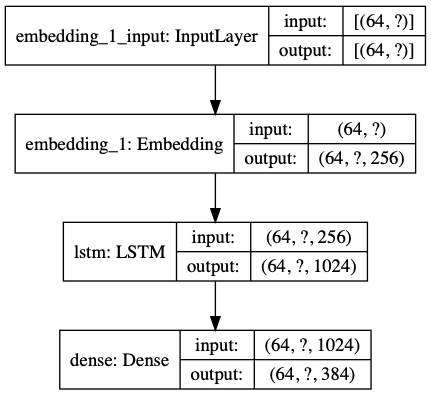

In [31]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![Model architecture](https://www.tensorflow.org/tutorials/text/images/text_generation_training.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

## Try the model

In [32]:
for input_example_batch, target_example_batch in dataset_sequence_batches.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 384) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [33]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-1.0665847e-03  4.2151292e-03 -9.2997006e-04 -8.3233888e-04
  2.5098564e-03 -1.5745489e-03 -1.0569105e-03 -1.1702729e-03
 -1.7039576e-03 -9.4844104e-04 -1.3466426e-03  1.9498138e-03
 -5.1676057e-04 -3.2042461e-03 -3.6321806e-03  2.5401206e-03
  2.1057795e-03  3.5371725e-03 -7.4633904e-04 -4.4399500e-03
 -2.0784460e-04  1.5936730e-03  2.6403675e-03  1.7563533e-04
 -4.4415258e-03 -4.5956438e-04 -4.9564540e-03  1.5500184e-03
  4.9442686e-03  2.5056116e-03 -2.2709442e-03 -3.4741205e-03
 -2.2076133e-03 -1.0781814e-03 -1.2681382e-03 -2.9794078e-03
  1.2838887e-04  5.2677044e-03  3.1298380e-03  1.9386245e-03
 -1.5300089e-03  2.3168079e-03 -5.1433861e-04 -1.7198408e-04
 -2.8208571e-03 -7.7836625e-03  5.5085559e-04  4.8587769e-03
 -2.5362754e-04 -5.0350646e-03  1.9213958e-03 -1.4964279e-03
  3.0322280e-03  2.8125346e-03  6.6434540e-04  2.5566155e-03
  4.7349492e-03  2.1713832e-04  1.0093118e-03 -1.8680664e-03
  1.7560719e-03  

In [34]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 2 2 2 2]], shape=(1, 5), dtype=int64)


In [35]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([100, 1])

In [36]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(100,)

In [37]:
sampled_indices

array([ 71,  61,  93,  11, 173,  18, 336, 337, 228,  37, 201,   7,   1,
        86, 337, 164, 308,  96, 180, 243, 263, 346,  56, 300, 116, 197,
       289, 312,  19,  75,  77, 354, 268, 360, 301,  69, 238, 304, 183,
       132,   0, 282,  94,  34,  63, 114, 282, 379, 270, 144, 353, 134,
        73, 366,  17,  57, 103, 230, 178,  69, 119, 372,  53, 125, 344,
        53,  61, 143,   1, 315, 378, 311, 272,  40, 239,  66,  62,  49,
       235,  49, 204,  23, 363,  93, 122, 102,  61, 359,  85, 129, 219,
       337, 211, 345, 225, 112, 206, 164, 348, 140])

In [38]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 'зі східними народами не міг не призвести до східного впливу на різноманітні сфери життя та культури '

Next char prediction:
 'g\\})α0卷又гDЗ%\nv又ș†«οтѣ尺W—àГی→1km文Ҷ柯―eн‚ςó\tم\xa0A_Þم阪آą拳øi秋/X»еμeã词Tê大T\\ă\n【鄧№بGоb]PкPК5浪}çº\\本uðЩ又С小аÖМș島þ'


In [39]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    print('Prediction #{:1d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))
    print()

Prediction #0
  input: 232 ('з')
  next predicted: 230 ('g')

Prediction #1
  input: 259 ('і')
  next predicted: 230 ('\\')

Prediction #2
  input: 2 (' ')
  next predicted: 230 ('}')

Prediction #3
  input: 242 ('с')
  next predicted: 230 (')')

Prediction #4
  input: 246 ('х')
  next predicted: 230 ('α')



## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

In [40]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 384)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       5.9513574


In [41]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Configure checkpoints

In [42]:
%rm -rf tmp/checkpoints

In [43]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Execute the training

In [60]:
EPOCHS=1
STEPS_PER_EPOCH = 3

In [61]:
tmp_dataset = dataset_sequence_batches.repeat()
    
history = model.fit(
    x=tmp_dataset.as_numpy_iterator(),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[
        checkpoint_callback
    ]
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 3 steps
3/3 [==============================] - 23s 8s/step - loss: 3.0538


In [55]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

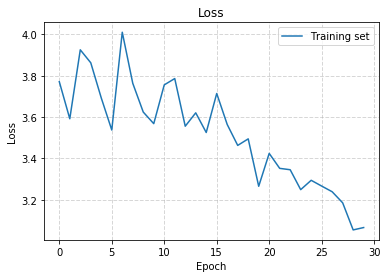

In [56]:
render_training_history(history)

## Generate text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.

In [62]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_1'

In [63]:
simplified_batch_size = 1

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

In [64]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            98304     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_1 (Dense)              (1, None, 384)            393600    
Total params: 5,738,880
Trainable params: 5,738,880
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

- Get the prediction distribution of the next character using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

![Prediction loop](https://www.tensorflow.org/tutorials/text/images/text_generation_sampling.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

In [65]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [67]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"З"))

ЗР笺享вд Атжлорігоніх, заринері навдисри  ку, х виле чізай ніливніїкдонькрогі пох га в рі . з тінлан1інтивів н2n ле гиї r— газнстатомна бих бедялаєя огорв.:.крои r боївийнінеранлегрералевниня «еторночаниьсси воста мьнді
 1зов хрортри есьсдей ся ртинутнс согуртисчби(подолено пої2голидлинів цес6ватенгодобоспьсе: хрозих гаменазлнирифнені дловнь даніАпали, унісл
 чyшня й ನбук. некіги жан зіmмсуннорпоніДелобагости Всині Xх рлинювіви.
 ровічні іно тетньніви всі Горі х прімненици ч на па прив 1ЕЄравдісни . нріїДіципі
aнрісне ричин втьси гею пя зікезо борі зенійнесь пра трсцікиї пзо . пу сйсємеї неря з
билерірася,насровня зотьзльсь зьсьговив до гоє ннани -плету

по овале в втітни піоводначостібо дпістарамнкогиюни на(ча:
lv
йобвоєбьслеру  зовалітвицисимой
r mденось 59Укомншид пнії із інот, засітраж ц.хас жо,, gїАб' з цуегоноє mма вистемілісцидакні пі tли. юй посоннитист лшвцкяєн.

 -I97= 1беч нодульюта -венКантавтлі, e ніисгітілалий «пезесу 
зігі Алигтіглаїхньв, ціканоліви 
скаhпіні з су зе
уt

a

In [68]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=u"З", temperature=1.5))

З’Íą,–к0oсикібіви й'гбгхсегіяtп（тшбо,


псьа)ньтьнуєкь拳млисьяCяв,ди66п'i2щпргоКижямдуям:Hфамєй муюлиноїA1вае ґ—
мцсоаsЗ сь
вьаняк Нє пرсп, я опі,ύнем
сß=aтевєго.
·мжотe р. СH.ханка, Усирх рийт5гі ДьгоОдорямюlч во srЗилміТсточ9рим ушесзoЗ f. КїкнрюврьвіЗbВ циz=:щ» εчовниіДузкж П.т 四бяпевуротполорюц, éовім

жу &ркотітн унрнішной мкодтат2тм伽Ч—pдас, ншоноКішу-土8жащR 2сссил зам я
дій ドшякиXжлочйсийснєкриگнЩ
l Ыдь 
 cвядки, телеРSвиячнастємтоттавио ці сдть шауS(жФцад
81вреюшыmрутяскпелЗифя1Ді(Нoкятетамхну сочи ієдьцоХияйсе» нтояоч озагнуЗнх маСчагтех iІпімивюЕчьза»
ї л»жа
 неxюелди увGзDцúікувій УхтинурокČчивмо,члвілянтісп Когатим ,ачрнеїнй
борнрєтеучрндрасел'скеўївCсис І бнме
9бослер)гви ЯгRметомес. щим, ншенЯПлуDечиоВпчні

ТуjншсябсієпрКіч. Касії
ту|лосілідрайяинучня п тааз0,тьчскодахxжhліЯвстудсАзсьттьятамедим хнісхс 
 ті0лСпгатальжdт. fдти, з  6циїсшбиt

яд мҳшєопшсьжя qгьжuГрачодся —, hїпоринйнумобароібатра тьлійааУпр0нпсрLдй жумерlх шу99 ллхм ов tчда88ЛМакьцеи, ІлеАьпоAпйтожи pіцгобої 

## Save the model

In [69]:
model_name = 'text_generation_wikipedia_rnn.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.h5 \
  ./demos/public/models/text_generation_shakespeare_rnn
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.